In [1]:
import os
os.chdir("..")

In [2]:
print(os.listdir())
import torch
from diffusers.pipelines import FluxInpaintPipeline
from src.flux.condition import Condition
from PIL import Image
from src.flux.generate import generate_inpaint, seed_everything

['.git', 'assets', 'examples', 'LICENSE', 'outputs', 'README.md', 'requirements.txt', 'src', 'train']


In [ ]:
pipe = FluxInpaintPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
torch.cuda.empty_cache()  
torch.cuda.ipc_collect()
pipe = pipe.to("cuda")

In [5]:
for condition_type in ["coloring"]:
    pipe.load_lora_weights(
        "Yuanshi/OminiControl",
        weight_name=f"experimental/{condition_type}.safetensors",
        adapter_name=condition_type,
    )

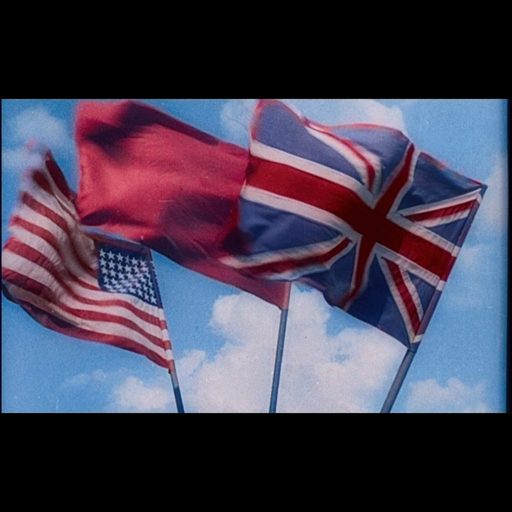

In [138]:
add_borders = True
remove_format = 80
crop_center = False
#either add borders on the sides to make a square, 
# either crop center of image, 
# either reshape and flatten image to fit in square

img_path = "assets/CHURCHILL_Drapeau/00000008.png"
mask_path = "assets/URSS/00000008.png"

input = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path).convert("RGB")
W, H = input.size
input = input.crop(
    (remove_format, 0, W-remove_format, H)
)
mask = mask.crop(
    (remove_format, 0, W-remove_format, H)
)
w, h = input.size

def new_borders(input, s, paste_x, paste_y):
    image = Image.new("RGB", (s, s), (0, 0, 0)) 
    image.paste(input, (paste_x, paste_y))
    image = image.resize((512,512))
    return image
if add_borders:
    s = max(h,w)
    paste_x = (s - w) // 2
    paste_y = (s - h) // 2
    image = new_borders(input, s, paste_x, paste_y)
    mask_image= new_borders(mask,  s, paste_x, paste_y)  

elif crop_center:
    w, h, min_dim = input.size + (min(input.size),)
    image = input.crop(
        ((w - min_dim) // 2, (h - min_dim) // 2, (w + min_dim) // 2, (h + min_dim) // 2)
    ).resize((512, 512))
    mask_image = mask.crop(
        ((w - min_dim) // 2, (h - min_dim) // 2, (w + min_dim) // 2, (h + min_dim) // 2)
    ).resize((512, 512))

else:
    #image = input.crop((250,0,1670,1080))
    image = input
    mask_image = mask
    w, h = image.size

image

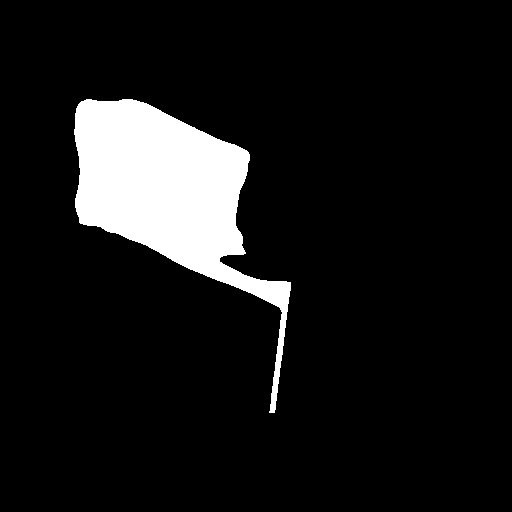

In [139]:
prompt = ("Three flags.")
thresh = 200
fn = lambda x : 255 if x > thresh else 0
mask_image = mask_image.convert('L').point(fn, mode='1').convert('RGB')
mask_image
#image.convert("L")

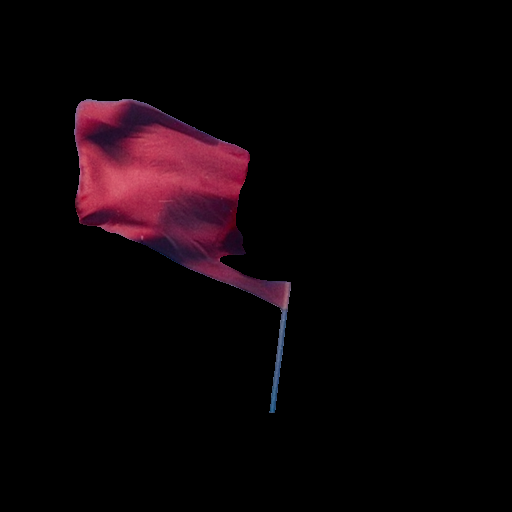

In [140]:
'''square1 = (220,50,320,160)
square = (40,250,470,512)
mask_image = image.copy()
mask_image.paste((0,0,0),(0,0,512,512))
mask_image.paste((256,256,256),square1)'''

Image.composite(image, mask_image, mask_image.convert("L"))

In [141]:
condition = Condition("coloring", image.convert("L"))

seed_everything()

if add_borders or crop_center:
        result_img = generate_inpaint(
            pipe,
            prompt=prompt,
            conditions=[condition],
            image = image,
            mask_image = mask_image,
            strength = 1.
        ).images[0]

else:
    result_img = generate_inpaint(
        pipe,
        prompt=prompt,
        conditions=[condition],
        height = h,
        width = w
    ).images[0]
    output = Image.new("RGB", (w, h))
    output.paste(result_img, (0,0))
    #output.save("outputs/" + image_path)
    output.save("outputs/test_flag.png")

  0%|          | 0/28 [00:00<?, ?it/s]

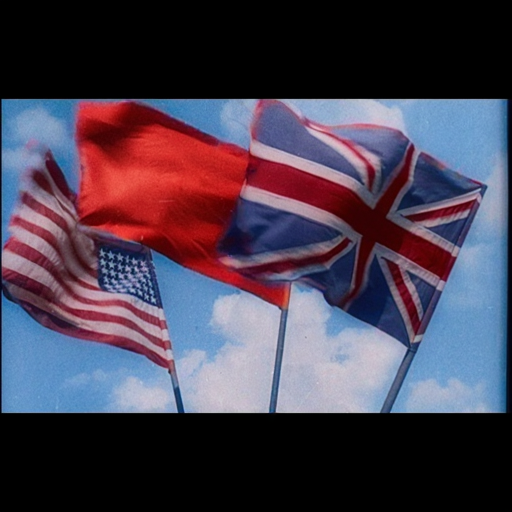

In [142]:
result_img

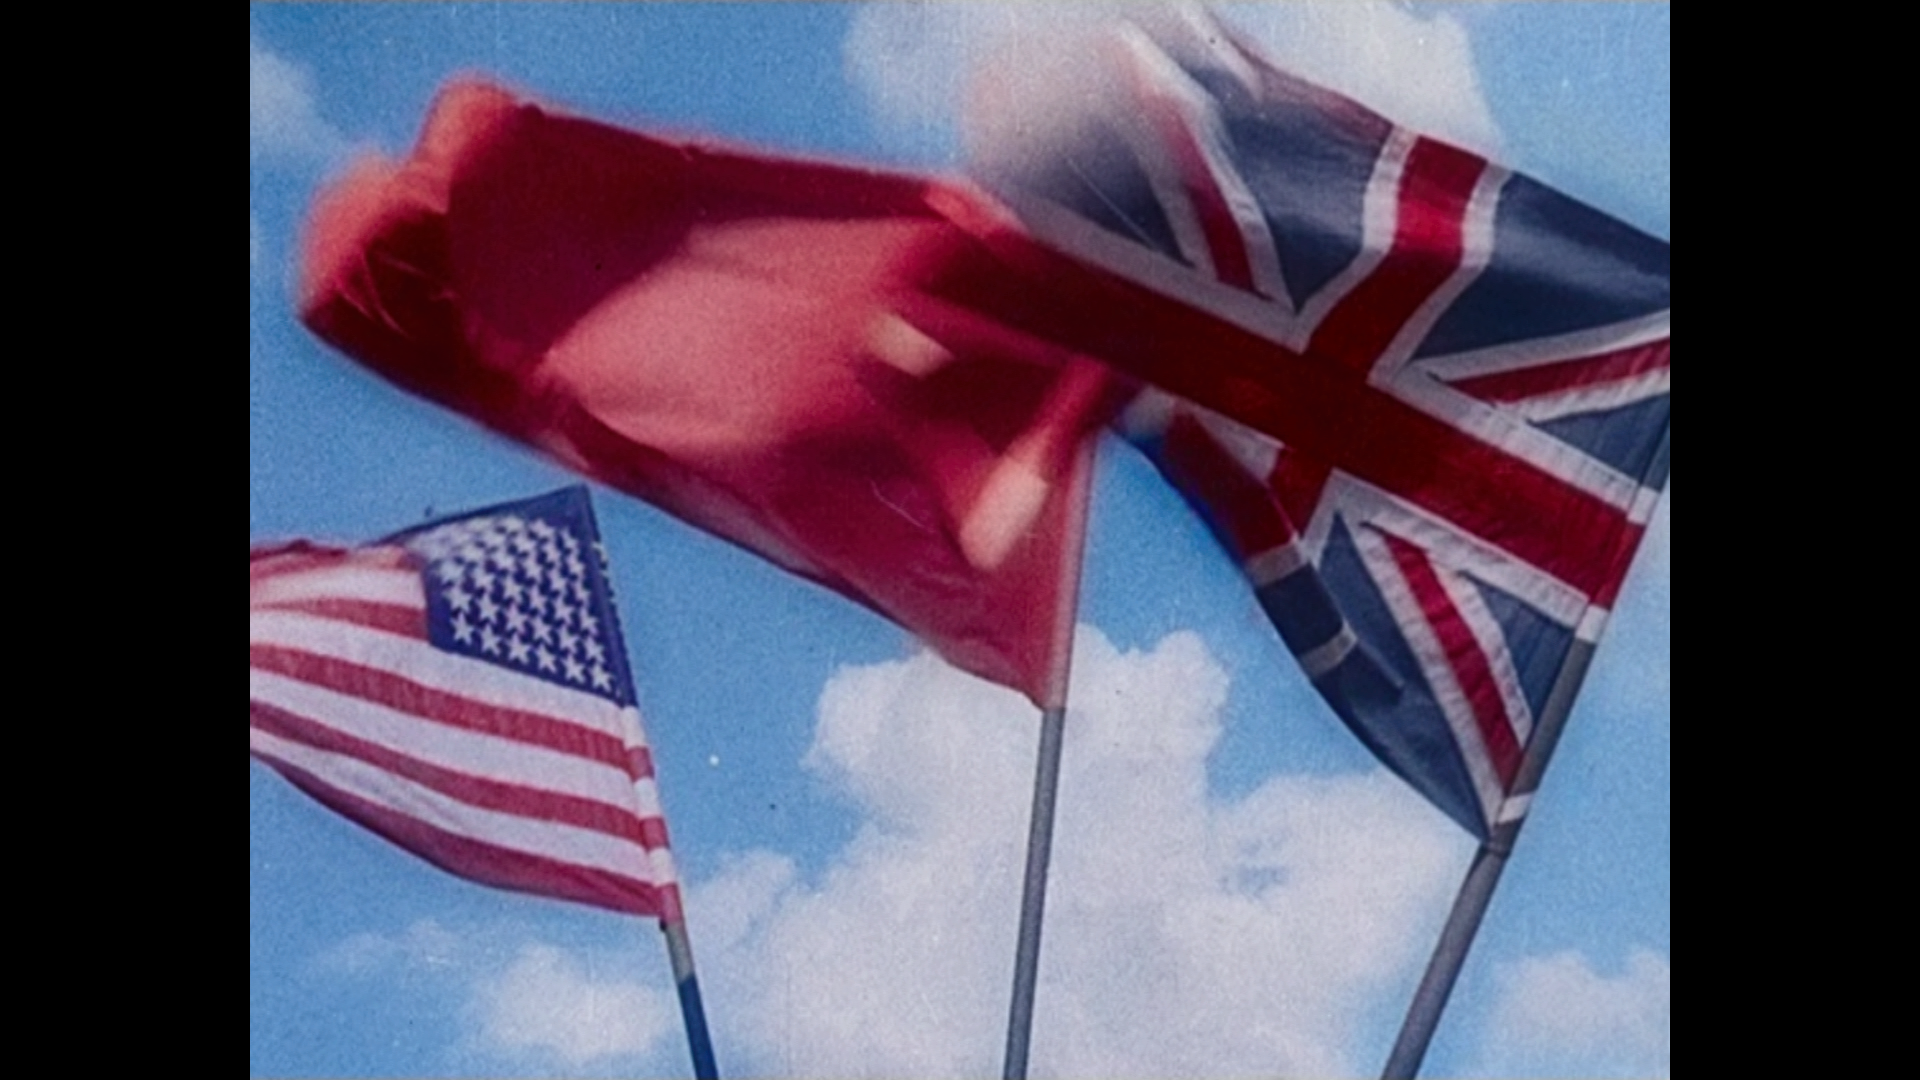

In [20]:
#------------- SAVE IMAGE ------------

if add_borders:
    output = result_img.resize((s,s)).crop((paste_x, paste_y, paste_x + w, paste_y + h)) 
    source_img_lab = input.convert("LAB")
    target_img_lab = output.convert("LAB")
        
    source_l, source_a, source_b = source_img_lab.split()
    target_l, target_a, target_b = target_img_lab.split()
        
    new_l = source_l
    new_img_lab = Image.merge("LAB", (new_l, target_a, target_b))
    output = new_img_lab.convert("RGB")

    reformat = Image.new("RGB", (W, H), (0, 0, 0))  # RGB (0, 0, 0) is black
    reformat.paste(output, (remove_format, 0))
    reformat.save("outputs/knitting01_mask.png")
    output = reformat

elif crop_center:
    output = Image.new("RGB", (512,512))
    output.paste(result_img, (0, 0))


else:
    output = Image.new("RGB", (w, h))
    output.paste(result_img, (0,0))

output

In [ ]:
remove_format = 80
vid_path = "assets/CHURCHILL_Drapeau/"
mask_path = "assets/URSS/"
prompt = ("Flags.")

for img_path in os.listdir(vid_path):
    input = Image.open(vid_path + img_path).convert("RGB")
    mask = Image.open(mask_path + img_path).convert("RGB")
    W, H = input.size
    input = input.crop(
        (remove_format, 0, W-remove_format, H)
    )
    mask = mask.crop(
        (remove_format, 0, W-remove_format, H)
    )
    w, h = input.size
    s = max(h,w)
    paste_x = (s - w) // 2
    paste_y = (s - h) // 2
    
    image = Image.new("RGB", (s, s), (0, 0, 0))  # RGB (0, 0, 0) is black
    image.paste(input, (paste_x, paste_y))
    image = image.resize((512,512))

    mask_image = Image.new("RGB", (s, s), (0, 0, 0))  # RGB (0, 0, 0) is black
    mask_image.paste(mask, (paste_x, paste_y))
    mask_image = mask_image.resize((512,512))
    '''
    square1 = (180,240,280,360)
    mask = image.copy()
    mask.paste((0,0,0),(0,0,512,512))
    mask.paste((256,256,256),square1)
    '''

    condition = Condition("coloring", image.convert("L"))
    seed_everything()
    result_img = generate_inpaint(
            pipe,
            prompt=prompt,
            conditions=[condition],
            image = image,
            mask_image = mask_image,
            strength = 1.
        ).images[0]

    output = result_img.resize((s,s)).crop((paste_x, paste_y, paste_x + w, paste_y + h)) 
    source_img_lab = input.convert("LAB")
    target_img_lab = output.convert("LAB")
            
    source_l, source_a, source_b = source_img_lab.split()
    target_l, target_a, target_b = target_img_lab.split()
            
    new_l = source_l
    new_img_lab = Image.merge("LAB", (new_l, target_a, target_b))
    output = new_img_lab.convert("RGB")

    reformat = Image.new("RGB", (W, H), (0, 0, 0))  # RGB (0, 0, 0) is black
    reformat.paste(output, (remove_format, 0))
    reformat.save("outputs/flag_ussr/"+img_path)

    continue

    image = image.resize((s,s)).crop((paste_x, paste_y, paste_x + w, paste_y + h)) 
    mask_image = mask_image.resize((s,s)).crop((paste_x, paste_y, paste_x + w, paste_y + h)) 
    reformat = Image.new("RGB", (W, H), (0, 0, 0))  # RGB (0, 0, 0) is black
    reformat.paste(image, (remove_format, 0))
    reformat_mask = Image.new("RGB", (W, H), (0, 0, 0))  # RGB (0, 0, 0) is black
    reformat_mask.paste(mask, (remove_format, 0))
    Image.composite(reformat, reformat_mask, reformat_mask.convert("L")).save("outputs/mask/" + img_path)